<a href="https://colab.research.google.com/github/zdwhite/Thinkful-Unit-3/blob/master/DRILL_Random_forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
y2015 = pd.read_csv(
    'https://www.dropbox.com/s/0so14yudedjmm5m/LoanStats3d.csv?dl=1',
    skipinitialspace=True,
    header=1)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [0]:
# Convert ID and Interest Rate to numeric.
y2015['id'] = pd.to_numeric(y2015['id'], errors='coerce')
y2015['int_rate'] = pd.to_numeric(y2015['int_rate'].str.strip('%'), errors='coerce')

# Drop other columns with many unique variables
y2015.drop(['url', 'emp_title', 'zip_code', 'earliest_cr_line', 'revol_util',
            'sub_grade', 'addr_state', 'desc'], 1, inplace=True)

In [0]:
# Remove two summary rows at the end that don't actually contain data.
y2015 = y2015[:-2]

In [5]:
from sklearn import ensemble
from sklearn.model_selection import cross_val_score

rfc = ensemble.RandomForestClassifier(n_estimators=5)
X = y2015.drop(['loan_status','id','member_id'], 1)
Y = y2015['loan_status']
X = pd.get_dummies(X)
X = X.dropna(axis=1)
print(cross_val_score(rfc, X, Y, cv=10).mean())

0.9765563406532554


#DRILL: Third Attempt

So here's your task. Get rid of as much data as possible without dropping below an average of 90% accuracy in a 10-fold cross validation.

You'll want to do a few things in this process. First, dive into the data that we have and see which features are most important. This can be the raw features or the generated dummies. You may want to use PCA or correlation matrices.

Can you do it without using anything related to payment amount or outstanding principal? How do you know?

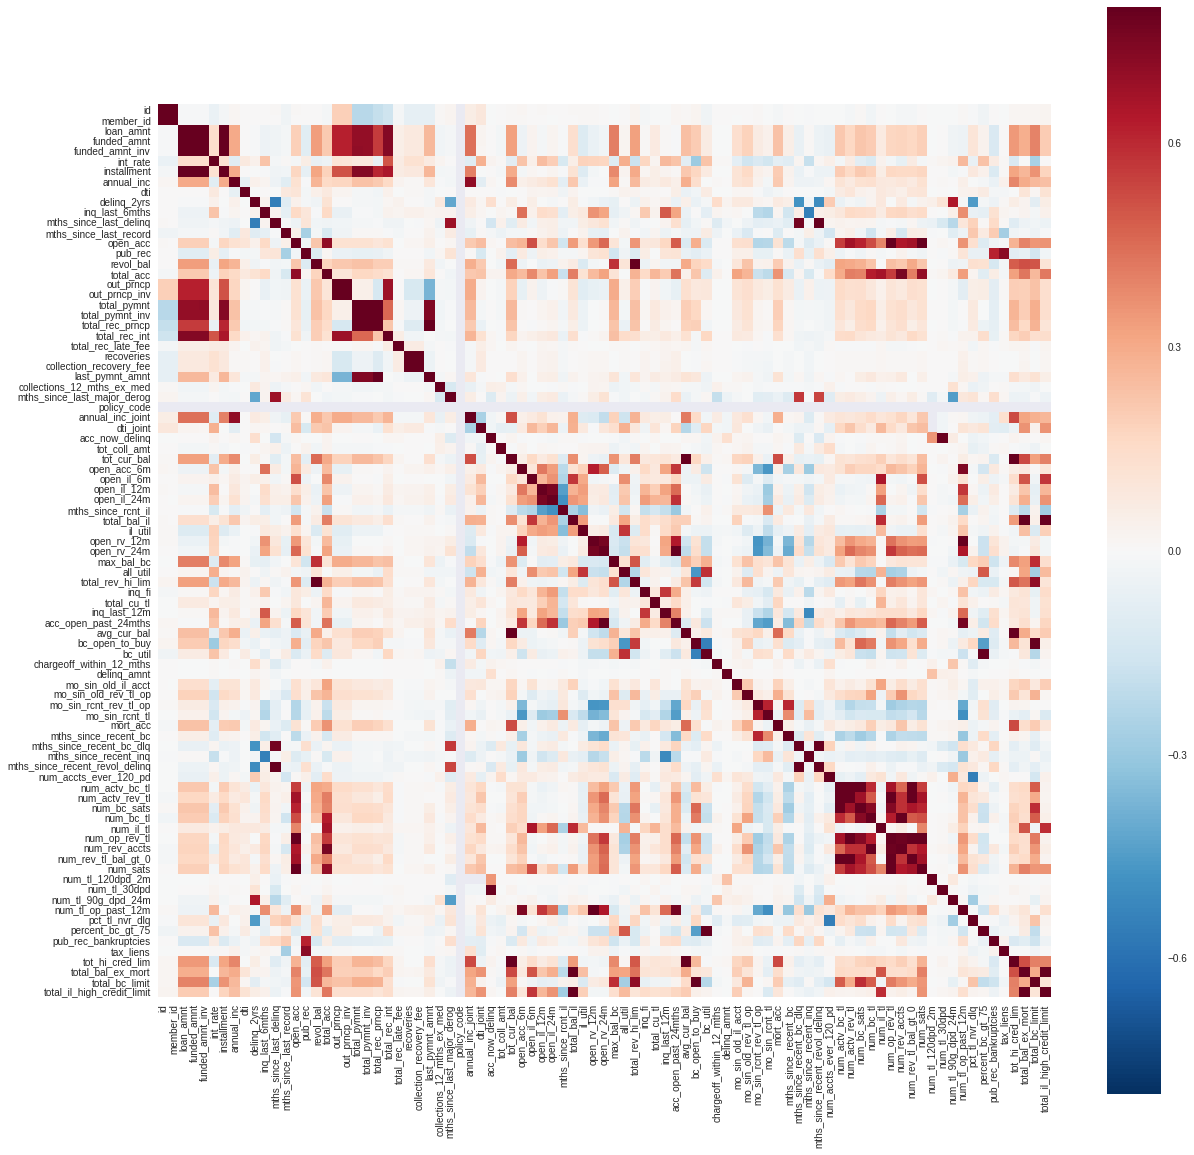

In [6]:
## Get a quick sense of correlation
f, ax = plt.subplots(figsize=(20,20))
corrmat = y2015.corr()
sns.heatmap(corrmat, vmax=.8, square=True)

# Toss Correlated Features

In [0]:
corrmat.fillna(0,inplace=True)

#Find all of the features that correlate with each other over .8

Features = pd.DataFrame([])

for row in corrmat:
  for element in corrmat.loc[row:row,]:
    if (corrmat.loc[row][element]>.8) &  (corrmat.loc[row][element] < 1):
      #if element in Features.index.values
      Features.loc[row,element]=corrmat.loc[row][element]
      #print(row,element,corrmat.loc[row][element])

### from the corrmat we can essentially create a dictionary of features that we can remove.
### Turn the filtered corrmat into a dictonary, Eliminate nan's and create a graph of keys
### In cases where multiple features correlate to one another 

from math import isnan
my_dict = Features.to_dict()
### Remove all the NaNs from the dictionary

def remove_nans(d):
    for key in d.copy():
        if type(d[key]) == float and isnan(d[key]):
            del d[key]
        elif type(d[key]) == dict:
            remove_nans(d[key]) 

In [0]:
remove_nans(my_dict)

In [0]:
# Create a list of features to be removed that correlate with one another
# Some will be duplicates but they are removed at the end
features_removed=[]
repeat = []
for key in my_dict:
  feature = []
  for sub_key in my_dict:
    if key in my_dict[sub_key].keys() and sub_key not in repeat:
      #for feature
      feature.append(sub_key)
      #print(key,sub_key,feature)
  repeat.append(key)  
  features_removed.extend(feature)

In [0]:
#Removed non duplicated features
# features_removed is an array of all the features we'll be taking out of our total set.
features_removed = (list(set(features_removed)))
features_removed

In [0]:
# basically member_id accounts for 100% of the variance but tells us 100% of nothing
# also remove the dependant variable 
features_removed=features_removed + ["member_id"] + ['loan_status']

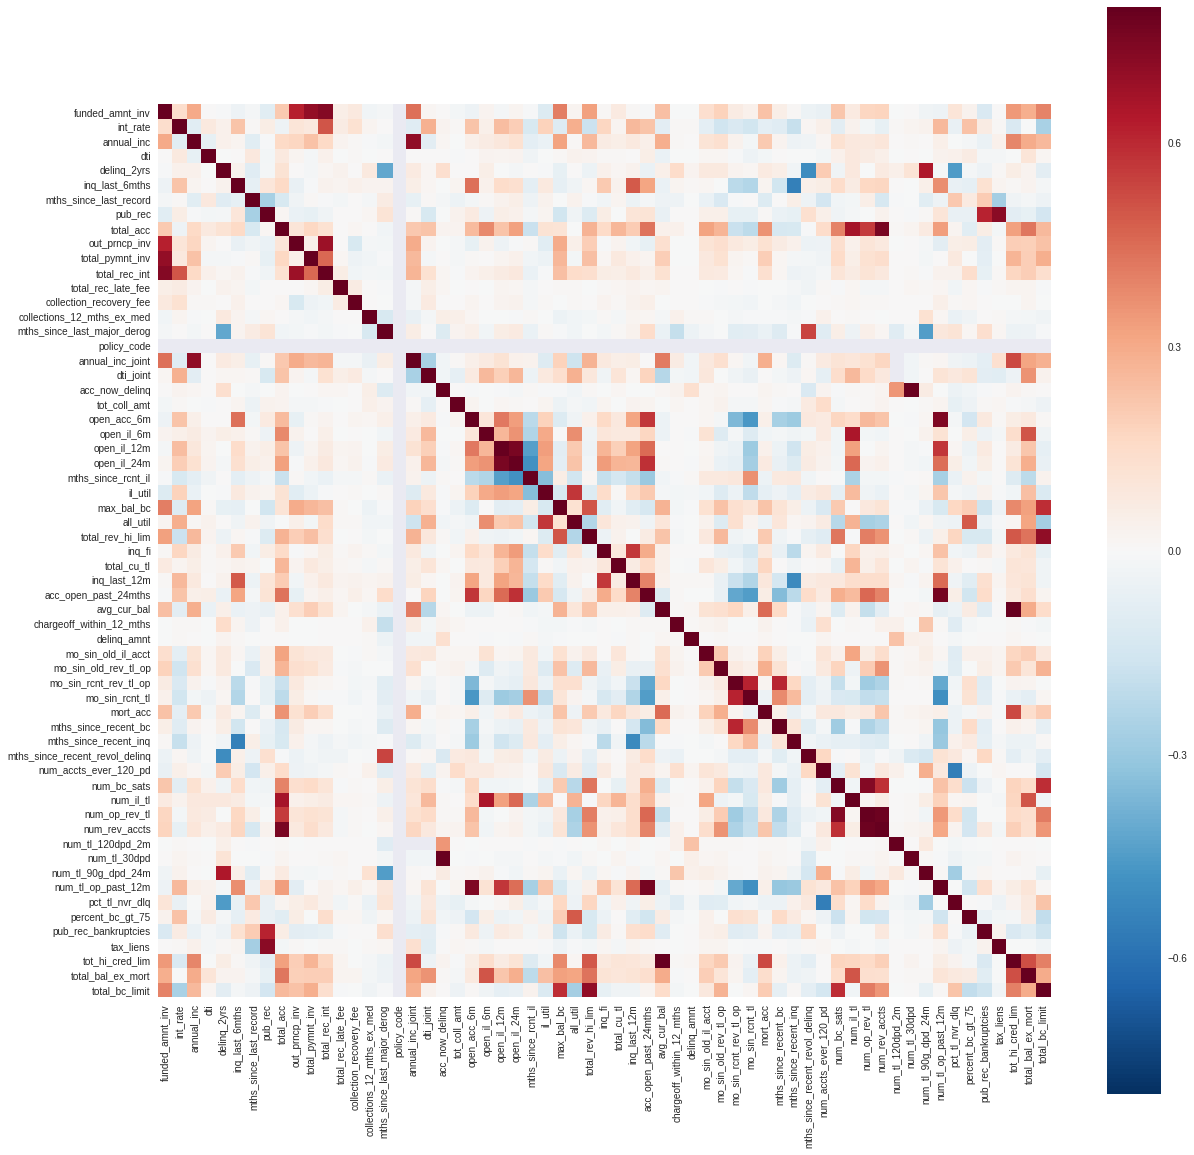

In [12]:
## Get a quick sense of correlation
f, ax = plt.subplots(figsize=(20,20))
corrmat = y2015.drop(features_removed,1).corr()
sns.heatmap(corrmat, vmax=.8, square=True)

Looking good we've removed a lot of correlated variables let's see how this runs.

In [14]:
from sklearn import ensemble
from sklearn.model_selection import cross_val_score

rfc = ensemble.RandomForestClassifier(n_estimators=5)
X = y2015.drop(features_removed, 1)
Y = y2015['loan_status']
X = pd.get_dummies(X)
X = X.dropna(axis=1)
print(cross_val_score(rfc, X, Y, cv=10).mean())



0.9673802144663272


Looks like our score hardly budged ! That's great to see time to just dump a bunch of data and see what happens, but before we do that let's justify this dump with some math.

## Dumping at random or dumping with math

Let's just start toss features like you're on a good will run.

In [36]:
#let's remove all of our correlated features and then remove the last 10

from sklearn import ensemble
from sklearn.model_selection import cross_val_score

rfc = ensemble.RandomForestClassifier(n_estimators=2)
X = y2015.drop(features_removed, 1)
Y = y2015['loan_status']
X = pd.get_dummies(X)
X = X.drop(X.columns[:10],1)
X = X.dropna(axis=1)

print(cross_val_score(rfc, X, Y, cv=10).mean())


0.92093396954547


92% getting closer lets drop a few more features and see how close we can get.

In [83]:
from sklearn import ensemble
from sklearn.model_selection import cross_val_score

rfc = ensemble.RandomForestClassifier(n_estimators=2)
X = y2015.drop(features_removed, 1)
Y = y2015['loan_status']
X = pd.get_dummies(X)
X = X.drop(X.columns[10:],1)
X = X.dropna(axis=1)


print(cross_val_score(rfc, X, Y, cv=10).mean())


0.8425224427515475


So we'll leave it here, when we only keep the first 11 features we jump up in accuracy quite a bit. It turns out that the total_pymnt_inv is a very importand feature for the accuracy of our model.

In [103]:
from sklearn import ensemble
from sklearn.model_selection import cross_val_score

rfc = ensemble.RandomForestClassifier(n_estimators=2)
X = y2015.drop(features_removed, 1)
Y = y2015['loan_status']
X = pd.get_dummies(X)
X.drop(X.columns[11:],1)
X = X.dropna(axis=1)


print(cross_val_score(rfc, X, Y, cv=10).mean())

0.9428988072380555


Now lets use some math on what and where we want to dump.

In [0]:
from matplotlib.mlab import PCA as mlabPCA
from sklearn import preprocessing
from sklearn.decomposition import PCA 

In [118]:
# Let's condense things down to 10 dimmensions 
sklearn_pca = PCA(n_components=10)

## use a standard scalar for our data we'll drop the dependant variable and the id columns

X = y2015.drop(['loan_status','id','member_id'],1)
X = pd.get_dummies(X)
X = X.dropna(axis=1)

data_scaled = pd.DataFrame(preprocessing.scale(X),columns = X.columns)

Y_sklearn = sklearn_pca.fit_transform(data_scaled)

print(
    'The percentage of total variance in the dataset explained by each',
    'component from Sklearn PCA.\n',
    sklearn_pca.explained_variance_ratio_
)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by the scale function.
  if __name__ == '__main__':


The percentage of total variance in the dataset explained by each component from Sklearn PCA.
 [0.05451767 0.03123227 0.02933637 0.02400215 0.01905831 0.01622973
 0.01527932 0.01332197 0.01301157 0.01180384]


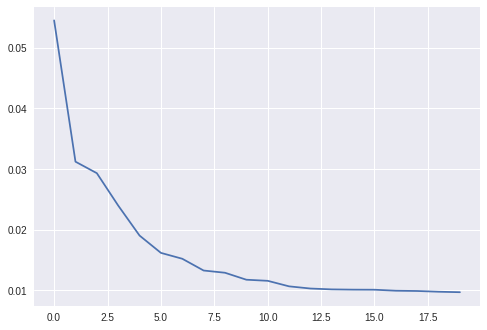

In [109]:
### THIS WAS RAN WITH 20 COMPONENTS DO NOT RE RUN #####
plt.plot(sklearn_pca.explained_variance_ratio_)

There looks to be fairly heavy diminishing returns past 10 components.

In [0]:
principalDf = pd.DataFrame(data = Y_sklearn)
FinalDf = pd.concat([principalDf, y2015['loan_status']], axis = 1)

### Run the model after all that math nonsense

In [128]:
from sklearn import ensemble
from sklearn.model_selection import cross_val_score

rfc = ensemble.RandomForestClassifier(n_estimators=2)
X = FinalDf.drop(['loan_status'], 1)
Y = FinalDf['loan_status']


print(cross_val_score(rfc, X, Y, cv=10).mean())

0.9162966977566566


WELL LOOK AT THAT all that fancy math later and we made out pretty well.